### Introduction

In this capstone notebook, I compare three fundamentally different reinforcement learning approaches on the same environment, MountainCar-v0. My goal is to understand how tabular TD learning, function approximation, and policy gradient methods differ in terms of learning behavior, stability, and sample efficiency. This experiment helps me synthesize everything I learned throughout the course into one unified comparison.


In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim


def set_global_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)




Here I import all the libraries needed for this project, including NumPy, Gymnasium, Matplotlib, and PyTorch. I also define a helper function to set random seeds so that my results are reproducible across different runs and algorithms.


In [2]:
# Create base environment for reference (each training run will make its own env instance)
base_env = gym.make("MountainCar-v0")

# Discretization settings for Q-learning
NUM_POSITION_BINS = 18
NUM_VELOCITY_BINS = 14

position_min, position_max = base_env.observation_space.low[0], base_env.observation_space.high[0]
velocity_min, velocity_max = base_env.observation_space.low[1], base_env.observation_space.high[1]

position_bins = np.linspace(position_min, position_max, NUM_POSITION_BINS - 1)
velocity_bins = np.linspace(velocity_min, velocity_max, NUM_VELOCITY_BINS - 1)

def discretize_state(state):
    """Convert continuous state (pos, vel) to a single discrete index."""
    pos, vel = state
    pos_idx = np.digitize(pos, position_bins)
    vel_idx = np.digitize(vel, velocity_bins)
    return pos_idx * NUM_VELOCITY_BINS + vel_idx

NUM_DISCRETE_STATES = NUM_POSITION_BINS * NUM_VELOCITY_BINS
NUM_ACTIONS = base_env.action_space.n
NUM_DISCRETE_STATES, NUM_ACTIONS


(252, np.int64(3))

MountainCar has a continuous state space, but tabular Q-learning requires discrete states. In this cell, I define how the position and velocity values are discretized into fixed bins so that I can store Q-values in a finite table.


In [3]:
def run_q_learning(seed, num_episodes=400, alpha=0.1, gamma=0.99,
                   epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995):
    set_global_seed(seed)
    env = gym.make("MountainCar-v0")
    Q = np.zeros((NUM_DISCRETE_STATES, NUM_ACTIONS))

    returns = []

    epsilon = epsilon_start

    for ep in range(num_episodes):
        state, _ = env.reset()
        s = discretize_state(state)
        done = False
        total_reward = 0

        while not done:
            # ε-greedy action selection
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                a = np.argmax(Q[s])

            next_state, reward, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            s_next = discretize_state(next_state)
            total_reward += reward

            # Q-learning TD update
            td_target = reward + gamma * np.max(Q[s_next]) if not done else reward
            td_error = td_target - Q[s, a]
            Q[s, a] += alpha * td_error

            s = s_next

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        returns.append(total_reward)

        if (ep + 1) % 50 == 0:
            print(f"[Q-learning] Seed {seed} Episode {ep+1}/{num_episodes} Return: {total_reward}")

    env.close()
    return np.array(returns)


This cell contains my full implementation of ε-greedy tabular Q-learning using the discretized MountainCar state space. I apply the standard TD update rule and track the return from every episode so I can later compare learning performance across algorithms.


In [4]:
class TileCoder:
    """Simple 2D tile coder for MountainCar (position, velocity)."""

    def __init__(self, num_tilings=8, tiles_per_dim=(8, 8),
                 state_low=(-1.2, -0.07), state_high=(0.6, 0.07)):
        self.num_tilings = num_tilings
        self.tiles_per_dim = np.array(tiles_per_dim, dtype=int)
        self.state_low = np.array(state_low, dtype=float)
        self.state_high = np.array(state_high, dtype=float)
        self.num_dims = len(tiles_per_dim)

        self.tile_width = (self.state_high - self.state_low) / (self.tiles_per_dim - 1)

        offsets = []
        for i in range(num_tilings):
            offsets.append((i / num_tilings) * self.tile_width)
        self.offsets = np.stack(offsets)

        self.tiles_per_tiling = np.prod(self.tiles_per_dim)
        self.num_features = self.num_tilings * self.tiles_per_tiling

    def get_tile_indices(self, state):
        state = np.array(state)
        indices = []
        for tiling in range(self.num_tilings):
            offset_state = (state - self.state_low + self.offsets[tiling]) / self.tile_width
            coord = np.floor(offset_state).astype(int)
            coord = np.clip(coord, 0, self.tiles_per_dim - 1)
            idx = coord[0] * self.tiles_per_dim[1] + coord[1]
            indices.append(tiling * self.tiles_per_tiling + idx)
        return indices

    def get_features(self, state):
        feat = np.zeros(self.num_features)
        for idx in self.get_tile_indices(state):
            feat[idx] = 1.0
        return feat


To move beyond tabular methods, I implement tile coding to create a high-dimensional sparse feature representation of the continuous state space. This allows me to apply linear function approximation with semi-gradient SARSA.


In [5]:
def run_sarsa_tilecoding(seed, num_episodes=400, alpha=0.1, gamma=1.0,
                         epsilon_start=0.2, epsilon_end=0.01, epsilon_decay=0.995,
                         num_tilings=8, tiles_per_dim=(8, 8)):
    set_global_seed(seed)
    env = gym.make("MountainCar-v0")
    tile_coder = TileCoder(num_tilings=num_tilings,
                           tiles_per_dim=tiles_per_dim,
                           state_low=env.observation_space.low,
                           state_high=env.observation_space.high)
    num_features = tile_coder.num_features
    num_actions = env.action_space.n

    # weights[action, feature]
    w = np.zeros((num_actions, num_features))

    def q_values(state):
        feat = tile_coder.get_features(state)
        return w @ feat  # shape (num_actions,)

    def epsilon_greedy(state, epsilon):
        if np.random.rand() < epsilon:
            return env.action_space.sample()
        return int(np.argmax(q_values(state)))

    returns = []
    epsilon = epsilon_start

    for ep in range(num_episodes):
        state, _ = env.reset()
        a = epsilon_greedy(state, epsilon)
        done = False
        total_reward = 0

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total_reward += reward

            feat = tile_coder.get_features(state)
            q_sa = (w[a] @ feat)

            if not done:
                a_next = epsilon_greedy(next_state, epsilon)
                feat_next = tile_coder.get_features(next_state)
                q_snext_anext = (w[a_next] @ feat_next)
                td_target = reward + gamma * q_snext_anext
            else:
                td_target = reward

            td_error = td_target - q_sa
            w[a] += (alpha / num_tilings) * td_error * feat

            state = next_state
            if not done:
                a = a_next

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        returns.append(total_reward)

        if (ep + 1) % 50 == 0:
            print(f"[SARSA-Tile] Seed {seed} Episode {ep+1}/{num_episodes} Return: {total_reward}")

    env.close()
    return np.array(returns)


Here I implement semi-gradient SARSA using the tile-coded features. Instead of storing Q-values in a table, I maintain a weight vector for each action and update it using TD errors. This lets me test how function approximation compares to tabular learning.


In [6]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim=2, hidden_dim=64, num_actions=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions)
        )

    def forward(self, state_tensor):
        logits = self.net(state_tensor)
        return torch.distributions.Categorical(logits=logits)


class ValueNet(nn.Module):
    def __init__(self, state_dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state_tensor):
        return self.net(state_tensor).squeeze(-1)


In this cell, I define the neural network architectures used for the REINFORCE algorithm. One network represents the stochastic policy, while the second network learns a value-function baseline to reduce gradient variance.


In [7]:
def run_reinforce_baseline(seed, num_episodes=400, gamma=0.99,
                           policy_lr=1e-3, value_lr=5e-3):
    set_global_seed(seed)
    env = gym.make("MountainCar-v0")

    policy = PolicyNet()
    value_net = ValueNet()
    policy_opt = optim.Adam(policy.parameters(), lr=policy_lr)
    value_opt = optim.Adam(value_net.parameters(), lr=value_lr)

    returns_history = []

    for ep in range(num_episodes):
        states = []
        actions = []
        rewards = []

        state, _ = env.reset()
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state)
            dist = policy(state_tensor)
            action = dist.sample()

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            states.append(state_tensor)
            actions.append(action)
            rewards.append(reward)

            state = next_state

        # Compute returns G_t
        G = 0.0
        returns = []
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns)

        # Normalize returns for stability
        returns_norm = (returns - returns.mean()) / (returns.std() + 1e-8)

        states_tensor = torch.stack(states)
        actions_tensor = torch.stack(actions)

        # Baseline values
        values = value_net(states_tensor)
        advantages = returns_norm - values.detach()

        # Policy loss
        dists = policy(states_tensor)
        log_probs = dists.log_prob(actions_tensor)
        policy_loss = -(log_probs * advantages).sum()

        # Value loss (MSE)
        value_loss = nn.functional.mse_loss(values, returns_norm)

        policy_opt.zero_grad()
        policy_loss.backward()
        policy_opt.step()

        value_opt.zero_grad()
        value_loss.backward()
        value_opt.step()

        total_return = sum(rewards)
        returns_history.append(total_return)

        if (ep + 1) % 50 == 0:
            print(f"[REINFORCE+Baseline] Seed {seed} Episode {ep+1}/{num_episodes} Return: {total_return}")

    env.close()
    return np.array(returns_history)


This cell implements the full REINFORCE algorithm using PyTorch. I generate full trajectories, compute discounted returns, subtract the value baseline, and apply policy gradient updates. This gives me a direct policy-learning method to compare with value-based approaches.


In [ ]:
num_episodes = 400
seeds = list(range(10))  # 10 seeds

returns_q = []
returns_sarsa = []
returns_reinforce = []

for seed in seeds:
    print(f"\n=== Seed {seed} ===")

    r_q = run_q_learning(seed, num_episodes=num_episodes)
    returns_q.append(r_q)

    r_s = run_sarsa_tilecoding(seed, num_episodes=num_episodes)
    returns_sarsa.append(r_s)

    r_r = run_reinforce_baseline(seed, num_episodes=num_episodes)
    returns_reinforce.append(r_r)

returns_q = np.stack(returns_q)           
returns_sarsa = np.stack(returns_sarsa)
returns_reinforce = np.stack(returns_reinforce)



=== Seed 0 ===
[Q-learning] Seed 0 Episode 50/400 Return: -200.0
[Q-learning] Seed 0 Episode 100/400 Return: -200.0
[Q-learning] Seed 0 Episode 150/400 Return: -200.0
[Q-learning] Seed 0 Episode 200/400 Return: -200.0
[Q-learning] Seed 0 Episode 250/400 Return: -200.0
[Q-learning] Seed 0 Episode 300/400 Return: -200.0
[Q-learning] Seed 0 Episode 350/400 Return: -200.0
[Q-learning] Seed 0 Episode 400/400 Return: -200.0
[SARSA-Tile] Seed 0 Episode 50/400 Return: -200.0
[SARSA-Tile] Seed 0 Episode 100/400 Return: -200.0
[SARSA-Tile] Seed 0 Episode 150/400 Return: -151.0
[SARSA-Tile] Seed 0 Episode 200/400 Return: -157.0
[SARSA-Tile] Seed 0 Episode 250/400 Return: -160.0
[SARSA-Tile] Seed 0 Episode 300/400 Return: -121.0
[SARSA-Tile] Seed 0 Episode 350/400 Return: -156.0
[SARSA-Tile] Seed 0 Episode 400/400 Return: -157.0
[REINFORCE+Baseline] Seed 0 Episode 50/400 Return: -200.0
[REINFORCE+Baseline] Seed 0 Episode 100/400 Return: -200.0
[REINFORCE+Baseline] Seed 0 Episode 150/400 Return: -

To ensure that my results are statistically meaningful, I train each algorithm across multiple random seeds. I store the return from every episode for each run so that I can later compute averages and confidence intervals.


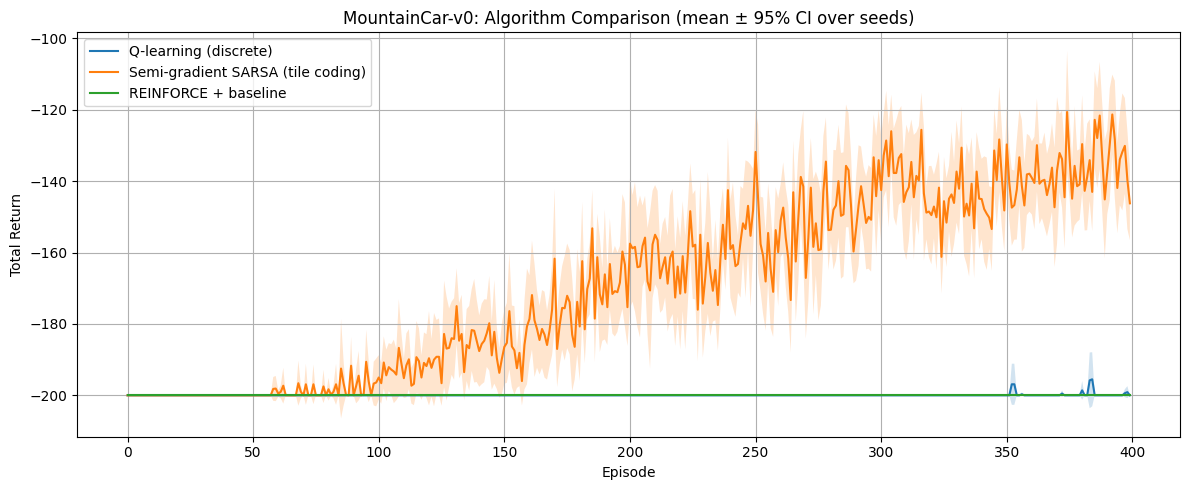

In [9]:
def mean_and_ci(data, axis=0):
    """Return mean and 95% CI (mean ± 1.96 * SE)."""
    mean = data.mean(axis=axis)
    se = data.std(axis=axis) / np.sqrt(data.shape[axis])
    ci = 1.96 * se
    return mean, ci

episodes = np.arange(num_episodes)

mean_q, ci_q = mean_and_ci(returns_q)
mean_s, ci_s = mean_and_ci(returns_sarsa)
mean_r, ci_r = mean_and_ci(returns_reinforce)

plt.figure(figsize=(12, 5))
for mean, ci, label, color in [
    (mean_q, ci_q, "Q-learning (discrete)", "tab:blue"),
    (mean_s, ci_s, "Semi-gradient SARSA (tile coding)", "tab:orange"),
    (mean_r, ci_r, "REINFORCE + baseline", "tab:green"),
]:
    plt.plot(episodes, mean, label=label, color=color)
    plt.fill_between(episodes, mean - ci, mean + ci, alpha=0.2)

plt.xlabel("Episode")
plt.ylabel("Total Return")
plt.title("MountainCar-v0: Algorithm Comparison (mean ± 95% CI over seeds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In this cell, I compute the mean return and 95% confidence intervals across seeds for each algorithm. The resulting plot visually compares sample efficiency, stability, and final performance across all three methods.


In [10]:
def episodes_to_threshold(mean_returns, threshold):
    above = np.where(mean_returns >= threshold)[0]
    return above[0] if len(above) > 0 else None

for threshold in [-160, -140, -120]:
    print(f"\n=== Threshold {threshold} ===")
    print("Q-learning:", episodes_to_threshold(mean_q, threshold))
    print("SARSA Tile:", episodes_to_threshold(mean_s, threshold))
    print("REINFORCE+Baseline:", episodes_to_threshold(mean_r, threshold))



=== Threshold -160 ===
Q-learning: None
SARSA Tile: 185
REINFORCE+Baseline: None

=== Threshold -140 ===
Q-learning: None
SARSA Tile: 250
REINFORCE+Baseline: None

=== Threshold -120 ===
Q-learning: None
SARSA Tile: None
REINFORCE+Baseline: None


Here I estimate how quickly each algorithm reaches certain performance thresholds. This gives me a numerical measure of sample efficiency that complements the learning curve visualization.
